# MDA project: predicting crowdedness in Leuven through noise and weather data

### Importing packages

In [1]:
import pandas as pd
import numpy as np
from matplotlib.patches import Patch
from sklearn.model_selection import TimeSeriesSplit
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_validate
from xgboost import XGBRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import Ridge
from sklearn.preprocessing import SplineTransformer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import FeatureUnion
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import KFold



### Loading data and adding time-related features

In [2]:
df = pd.read_csv("C:\\Users\Arthur\hello\\final_df.csv", delimiter=";")
df['result_timestamp'] = pd.to_datetime(df['result_timestamp'], format='%Y-%m-%d %H:%M:%S')
#select only three locations close to Oude Markt
df = df[df['object_id']<255442]

In [3]:
df

,object_id,result_timestamp,laeq,hour,day_of_week,month,weekend,holiday,exam_period,key,...,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
0,255441,2022-01-01 00:00:00,63.267554,0,5,1,True,True,False,2554412022-01-01 00:00:00,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,255441,2022-01-01 00:10:00,60.254000,0,5,1,True,True,False,2554412022-01-01 00:10:00,...,0.0,0.0,0.0,-48.0,0.04,0.0,13.28,13.28,13.223,13.23639
8,255441,2022-01-01 00:20:00,55.143907,0,5,1,True,True,False,2554412022-01-01 00:20:00,...,0.0,0.0,0.0,45.0,0.02,0.0,13.28,13.28,13.223,13.16699
12,255441,2022-01-01 00:30:00,58.230167,0,5,1,True,True,False,2554412022-01-01 00:30:00,...,0.0,0.0,0.0,-52.0,0.04,0.0,13.28,13.28,13.223,13.19886
16,255441,2022-01-01 00:40:00,54.220466,0,5,1,True,True,False,2554412022-01-01 00:40:00,...,0.0,0.0,0.0,34.0,0.02,0.0,13.28,13.28,13.223,13.16699
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332425,255441,2022-12-31 23:10:00,53.712833,23,5,12,True,True,False,2554412022-12-31 23:10:00,...,0.0,0.0,0.0,-9.0,0.40,0.0,16.61,16.61,16.553,16.52797
332431,255441,2022-12-31 23:20:00,55.333167,23,5,12,True,True,False,2554412022-12-31 23:20:00,...,0.0,0.0,0.0,5.0,0.29,0.0,16.61,16.61,16.553,16.57995
332437,255441,2022-12-31 23:30:00,56.797333,23,5,12,True,True,False,2554412022-12-31 23:30:00,...,0.0,0.0,0.0,-17.0,0.15,0.0,16.51,16.51,16.453,16.44846
332443,255441,2022-12-31 23:40:00,61.010667,23,5,12,True,True,False,2554412022-12-31 23:40:00,...,0.0,0.0,0.0,-31.0,0.29,0.0,16.49,16.49,16.433,16.46641


Test split (reserve last 20% of time series data, with a 1 week gap in between)

In [4]:
# creating train/validation data and test data
df_first80 = df.iloc[:102224,:]
df_last20 = df.iloc[105249:,:]
df_last20

,object_id,result_timestamp,laeq,hour,day_of_week,month,weekend,holiday,exam_period,key,...,LC_RAD,LC_RAININ,LC_DAILYRAIN,LC_WINDDIR,LC_WINDSPEED,LC_RAD60,LC_TEMP_QCL0,LC_TEMP_QCL1,LC_TEMP_QCL2,LC_TEMP_QCL3
249648,255439,2022-10-11 01:30:00,63.628500,1,1,10,False,False,False,2554392022-10-11 01:30:00,...,0.0,0.0,0.0,0.0,0.00,0.0,6.88,6.88,6.823,6.879301
249649,255440,2022-10-11 01:30:00,50.343000,1,1,10,False,False,False,2554402022-10-11 01:30:00,...,0.0,0.0,0.0,0.0,0.00,0.0,6.88,6.88,6.823,6.879301
249650,255441,2022-10-11 01:30:00,50.911500,1,1,10,False,False,False,2554412022-10-11 01:30:00,...,0.0,0.0,0.0,0.0,0.00,0.0,6.88,6.88,6.823,6.879301
249654,255439,2022-10-11 01:40:00,62.877167,1,1,10,False,False,False,2554392022-10-11 01:40:00,...,0.0,0.0,0.0,0.0,0.00,0.0,6.76,6.76,6.703,6.758009
249655,255440,2022-10-11 01:40:00,50.879833,1,1,10,False,False,False,2554402022-10-11 01:40:00,...,0.0,0.0,0.0,0.0,0.00,0.0,6.76,6.76,6.703,6.758009
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
332425,255441,2022-12-31 23:10:00,53.712833,23,5,12,True,True,False,2554412022-12-31 23:10:00,...,0.0,0.0,0.0,-9.0,0.40,0.0,16.61,16.61,16.553,16.527970
332431,255441,2022-12-31 23:20:00,55.333167,23,5,12,True,True,False,2554412022-12-31 23:20:00,...,0.0,0.0,0.0,5.0,0.29,0.0,16.61,16.61,16.553,16.579950
332437,255441,2022-12-31 23:30:00,56.797333,23,5,12,True,True,False,2554412022-12-31 23:30:00,...,0.0,0.0,0.0,-17.0,0.15,0.0,16.51,16.51,16.453,16.448460
332443,255441,2022-12-31 23:40:00,61.010667,23,5,12,True,True,False,2554412022-12-31 23:40:00,...,0.0,0.0,0.0,-31.0,0.29,0.0,16.49,16.49,16.433,16.466410


### Exploratory data analyses

Preprocessing pipeline: delaying noise and weather

In [5]:
#pipeline to create feature matrix with delayed noise and weather data, as well as target vector.

def delay_noise_weather(df):
    # Select columns for df_noisedelay
    df_noisedelay = df.loc[:, ['object_id', 'result_timestamp', 'laeq']]

    # Add 6 hours to result_timestamp
    df_noisedelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_noisedelay['key'] = df_noisedelay['object_id'].astype(str) + df_noisedelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_noisedelay = df_noisedelay.drop(['object_id', 'result_timestamp'], axis=1)

    # Select columns for df_weatherdelay
    df_weatherdelay = df.loc[:, ['object_id', 'result_timestamp', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                          'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0']]

    # Add 6 hours to result_timestamp
    df_weatherdelay['result_timestamp'] += pd.DateOffset(hours=6)

    # Create key column
    df_weatherdelay['key'] = df_weatherdelay['object_id'].astype(str) + df_weatherdelay['result_timestamp'].astype(str)

    # Drop unnecessary columns
    df_weatherdelay = df_weatherdelay.drop(['object_id', 'result_timestamp'], axis=1)

    #Drop noise and weather-related columns from original df
    df = df.drop(['laeq', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD', 'LC_RAININ',
                  'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60', 'LC_TEMP_QCL0'], axis=1)
    df['key'] = df['object_id'].astype(str) + df['result_timestamp'].astype(str)

    # Merge df with df_noisedelay and df_weatherdelay on 'key'
    merged_df = pd.merge(df, df_noisedelay, on='key').merge(df_weatherdelay, on='key')

    # Delete observations with missing values
    merged_df = merged_df.dropna()

    # Create feature matrix X and target vector y
    X = merged_df.drop(['result_timestamp', 'laeq', 'key', 'object_id','255442', '255443', '255444', '255445',
       '280324', '303910'], axis=1)
    y = merged_df['laeq']

    # Return full dataframe with delays, return feature matrix X and target vector y
    return merged_df, X, y

#Apply to df
merged_df, X, y = delay_noise_weather(df_first80)
    

In [6]:
X.columns

Index(['hour', 'day_of_week', 'month', 'weekend', 'holiday', 'exam_period',
       '255439', '255440', '255441', 'LC_TEMP_QCL1', 'LC_TEMP_QCL2',
       'LC_TEMP_QCL3', 'LC_HUMIDITY', 'LC_DWPTEMP', 'LC_n', 'LC_RAD',
       'LC_RAININ', 'LC_DAILYRAIN', 'LC_WINDDIR', 'LC_WINDSPEED', 'LC_RAD60',
       'LC_TEMP_QCL0'],
      dtype='object')

### Pipelines to fit all models (with cross-validation and hyperparameter tuning)

Create pipeline for Ridge with spline transformations

In [7]:

def periodic_spline_transformer(period, n_splines=None, degree=3):
    if n_splines is None:
        n_splines = period
    n_knots = n_splines + 1  # periodic and include_bias is True
    return SplineTransformer(
        degree=degree,
        n_knots=n_knots,
        knots=np.linspace(0, period, n_knots).reshape(n_knots, 1),
        extrapolation="periodic",
        include_bias=True,
    )
#creating spline transformers
cyclic_spline_transformer = ColumnTransformer(
    transformers=[
        ("cyclic_month", periodic_spline_transformer(12, n_splines=6), ["month"]),
        ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day"]),
        ("cyclic_hour", periodic_spline_transformer(24, n_splines=12), ["hour"]),
    ],
    remainder=MinMaxScaler(),
)

#creating interactions
hour_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

day_holiday_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_weekday", periodic_spline_transformer(7, n_splines=3), ["day"]),
            ("holiday", FunctionTransformer(lambda x: x == 1), ["holiday"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

hour_weekend_interaction = make_pipeline(
    ColumnTransformer(
        [
            ("cyclic_hour", periodic_spline_transformer(24, n_splines=8), ["hour"]),
            ("weekend", FunctionTransformer(lambda x: x == 1), ["weekend"]),
        ]
    ),
    PolynomialFeatures(degree=2, interaction_only=True, include_bias=False),
)

#adding combining the spline pipeline and the interactions pipeline
Ridge_splines = make_pipeline(
    FeatureUnion(
        [
            ("marginal", cyclic_spline_transformer),
            ("interactions1", hour_weekend_interaction),
            ("interactions2",day_holiday_interaction ),
            ("interactions3",hour_holiday_interaction),
            
        ]
    ),
    Ridge(),
)

5-fold cross validation object

In [8]:
cv = KFold(n_splits=5, shuffle=True)

Evaluate different models and select best performing model

In [9]:
def evaluate_models(X, y, cv, models):
    best_model = None
    best_rmse = float('inf')

    for model in models:
        if isinstance(model, XGBRegressor):
            # Parameter grid for XGBoost model
            param_grid = {
                'learning_rate': [0.05, 0.06],
                'n_estimators': [100, 110],
                'max_depth': [5, 6]
            }
        elif isinstance(model, HistGradientBoostingRegressor):
            # Parameter grid for HistGradientBoostingRegressor model
            param_grid = {
                'learning_rate': [0.05, 0.06],
                'max_leaf_nodes': [9, 10]
            }
        elif isinstance(model, Pipeline) and isinstance(model.steps[-1][1], Ridge):
            # Parameter grid for Ridge model with splines 
            param_grid = {
                "ridge__alpha": np.logspace(-6, 6, 25)
            }
        else:
            # Use default hyperparameters for other models
            best_model = model
            print(f"Using default hyperparameters for model: {type(model).__name__}")
            continue

        # Define custom scorer using mean squared error
        scorer = 'neg_mean_squared_error'

        # Perform grid search with time series cross-validation
        grid_search = GridSearchCV(model, param_grid=param_grid, cv=cv, scoring=scorer)
        grid_search.fit(X, y)

        # Get the best parameters and score from the search
        best_params = grid_search.best_params_
        score = -grid_search.best_score_
        print(f"Results of Grid Search for model: {type(model).__name__}")
        print(f"Best Parameters: {best_params}")
        print(f"Best Score: {score}")

        # Evaluate each model using time series cross-validation
        cv_results = cross_validate(
            model.set_params(**best_params),
            X,
            y,
            cv=cv,
            scoring=["neg_mean_absolute_error", "neg_root_mean_squared_error"],
        )
        mae = -cv_results["test_neg_mean_absolute_error"]
        rmse = -cv_results["test_neg_root_mean_squared_error"]
        print(
            f"Mean Absolute Error:     {mae.mean():.3f} +/- {mae.std():.3f}\n"
            f"Root Mean Squared Error: {rmse.mean():.3f} +/- {rmse.std():.3f}"
        )

        if np.mean(rmse) < best_rmse:
            best_model = model.set_params(**best_params)
            best_rmse = np.mean(rmse)

    return best_model


# Define the models to evaluate
models = [XGBRegressor(), HistGradientBoostingRegressor()]

# Example usage with multiple models
best_model = evaluate_models(X, y, cv, models)


Results of Grid Search for model: XGBRegressor
Best Parameters: {'learning_rate': 0.06, 'max_depth': 6, 'n_estimators': 110}
Best Score: 6.661415260984754
Mean Absolute Error:     1.757 +/- 0.008
Root Mean Squared Error: 2.578 +/- 0.040
Results of Grid Search for model: HistGradientBoostingRegressor
Best Parameters: {'learning_rate': 0.06, 'max_leaf_nodes': 10}
Best Score: 8.183406245191609
Mean Absolute Error:     1.960 +/- 0.014
Root Mean Squared Error: 2.855 +/- 0.032


In [10]:
best_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.06, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=110, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

#### Get final out-of-sample RMSE of XGBoost, using df_last20

In [18]:
#create X_test
merged_df_test, X_test, y_test = delay_noise_weather(df_last20)

#fit best model on train and validation data
best_model.fit(X, y)

#create predictions for test range
best_model_predictions = best_model.predict(X_test)

# Calculate the mean squared error
mse = mean_squared_error(y_test, best_model_predictions)

# Calculate the root mean squared error
rmse = np.sqrt(mse)
print(f"RMSE = {rmse}")
#3.73522


RMSE = 3.735220738939527


### Visualization of results of final model

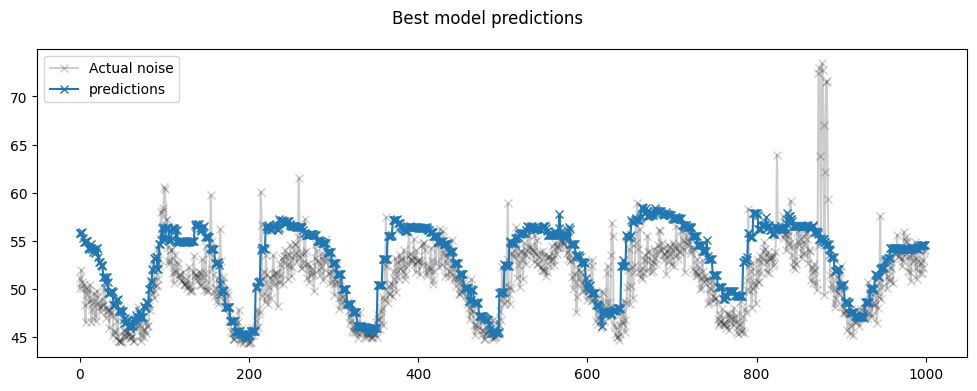

In [12]:
#visualization of model predictions, trained on full data

last_hours = slice(-1000, None)
fig, ax = plt.subplots(figsize=(12, 4))
fig.suptitle("Best model predictions")
ax.plot(
    y_test.values[last_hours],
    "x-",
    alpha=0.2,
    label="Actual noise",
    color="black",
)
ax.plot(best_model_predictions[last_hours], "x-", label="predictions")
_ = ax.legend()


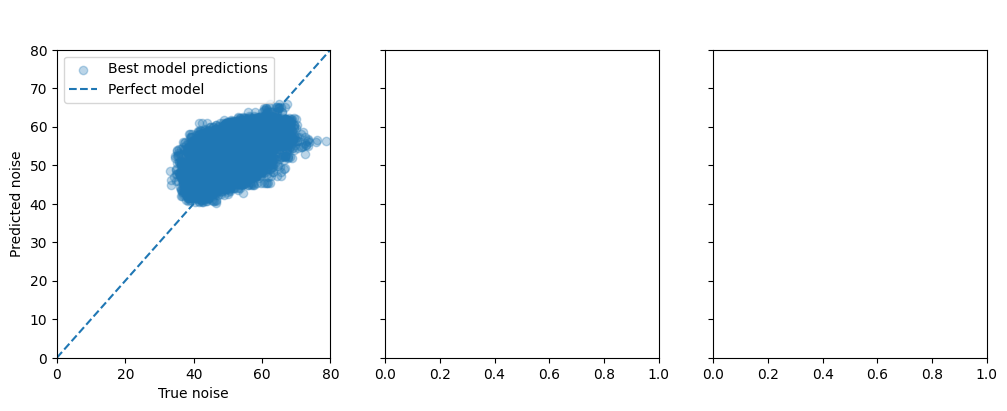

In [13]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey=True)
fig.suptitle(" ")
predictions = [
    best_model_predictions,
]
labels = [
    "Best model predictions",
]
for ax, pred, label in zip(axes, predictions, labels):
    ax.scatter(y_test.values, pred, alpha=0.3, label=label)
    ax.plot([0, 80], [0, 80], "--", label="Perfect model")
    ax.set(
        xlim=(0, 80),
        ylim=(0, 80),
        xlabel="True noise",
        ylabel="Predicted noise",
    )
    ax.legend()

plt.show()

Shapley values